In [ ]:
#!pip install matplotlib-label-lines

 # 9Nodes  SiouxFalls  EasternMassachusetts Anaheim berlin-mitte-prenzlauerberg-friedrichshain-center ChicagoSketch
CityName = 'SiouxFalls'

In [ ]:
import numpy as np

if CityName == 'SiouxFalls':
    NewLinkIds = np.array([1,   3, 12 , 15 , 33 , 36 , 47 , 22 , 49 , 52 , 57 , 45 , 41  ,44 ,42 ,71])
    NewLinkCost = np.array([5,3, 2, 6, 4, 5, 2, 5, 4, 6, 5, 3, 4 ,5  ,3,4])
    Budjet = 45
elif CityName == '9Nodes':
    NewLinkIds = np.array([24,6,9,17,14,18]) 
    NewLinkCost = np.array([8 * 10**3, 4 * 10**3,9 * 10**3,7 * 10**3,6 * 10**3,6.5 * 10**3])
    Budjet = 20 * 10**3
elif CityName == 'EasternMassachusetts':
    NewLinkIds = np.array([79,80, 100,101 ,123,124, 147])
    NewLinkCost = np.array([2.4 * 10**6, 2.4 * 10**6, 2.1 * 10**6, 2.1 * 10**6, 2.2 * 10**6,2.2 * 10**6, 1.9 * 10**6])#, 1.9 * 10**6, 1.8 * 10**6, 1.8 * 10**6])
    Budjet = 9 * 10**6
elif CityName == 'Anaheim':
    NewLinkIds = np.array([636,719, 771,718])# ,665,699, 414,451, 428,483])
    NewLinkCost = np.array([4 * 10**9, 5 * 10**9, 7 * 10**9, 8 * 10**9])#, 58 * 10**9,44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9])
    Budjet = 12 * 10**9
elif CityName == 'berlin-mitte-prenzlauerberg-friedrichshain-center':
    NewLinkIds = np.array([636,719, 771,718])# ,665,699, 414,451, 428,483])
    NewLinkCost = np.array([4 * 10**9, 5 * 10**9, 7 * 10**9, 8 * 10**9])#, 58 * 10**9,44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9])
    Budjet = 12 * 10**9
elif CityName == 'ChicagoSketch':
    NewLinkIds = np.array([1536,829, 2331,619 ,75,1700, 2014,1951])#, 628,883])
    NewLinkCost = np.array([6 * 10**9, 7 * 10**9, 4 * 10**9, 5 * 10**9, 8 * 10**9,3 * 10**9, 5 * 10**9, 1 * 10**9])#, 86 * 10**9, 58 * 10**9])
    Budjet = 16 * 10**9



########################################



In [ ]:
from pyomo.environ import *
from datetime import datetime
import networkx as nx
import sqlite3 
import os
import sys


from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
from labellines import labelLines

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sdNetworkUtility  import *
from Utility.sdUtility  import *
from sdTapPyomo  import *
from sdLIPSolver2TermObj  import *
#----------------------------------
np. set_printoptions(threshold=np. inf)


In [ ]:
#در ساختار شبکه در جدول نودها فرض شده که نودهایی که می توانند مبدا یا مقصد یک زوج مبدا مقصد باشند(زون هستند)در همان ابندای جدول و از اندیس
#1 - n
#آمده اند و فیلد 
#is_OD 
#آنها 1 است


#--توجه شود که در داخل دیتابیس اطلاعات بصورت زیر است
# free Flow Time به دقیقه
#ظرفیت  بر حسب تعداد خودرو در روز
# تقاضای سفر بر حسب تعداد خودرو در روز
#طول یالها بر حسب متر


# Create a SQL connection to our SQLite database               # 9Nodes  SiouxFalls Anaheim EasternMassachusetts
con = sqlite3.connect("../TraficAssignment/1_project/" + CityName + "/project_database.sqlite")
cur = con.cursor()
G = nx.DiGraph()

List_D_Nodes = []
##مشخص کردن تعداد Dها
cur.execute('SELECT node_id FROM nodes where is_OD = 1 ')
Data= cur.fetchall()
for row in Data: #---
    List_D_Nodes.append(row[0])
NodeDCount = len(List_D_Nodes)


In [ ]:
#------ساختن لیست نودها-------
cur.execute('SELECT node_id FROM nodes ')
Data= cur.fetchall()
AllNodesCount = len(Data);
AllNodesCount
ListNode =[*(range(1,AllNodesCount+1))]


In [ ]:
LinkCap_Matrix =  np.zeros((AllNodesCount,AllNodesCount))
LinkFreeFlowTime_Matrix =  np.zeros((AllNodesCount,AllNodesCount))
LinkDistance_Matrix =  np.zeros((AllNodesCount,AllNodesCount))
LinkCost_Matrix = np.zeros((AllNodesCount,AllNodesCount)) 
LinkCost_Matrix
#---شبکه اصلی + تمام لینکهای کاندیدا
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time,distance FROM links order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data: #---We use free_flow_time As weight of edges for compute K-Shortest path
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4],distance=row[5])
    LinkCap_Matrix[row[0]-1,row[1]-1] = row[3]
    LinkFreeFlowTime_Matrix[row[0]-1,row[1]-1] = row[4]
    LinkDistance_Matrix[row[0]-1,row[1]-1] = row[5]
    for p in range(len(NewLinkIds)):
        if(row[2] == NewLinkIds[p]):
            LinkCost_Matrix[row[0]-1,row[1]-1] = NewLinkCost[p]

    
#print('LinkCap_Matrix =  ',LinkCap_Matrix)
#print(LinkFreeFlowTime_Matrix)
#print(LinkDistance_Matrix)
# تقاضا بین زوجها
TmpODDeman_Matrix = pd.read_excel(r'../TraficAssignment/0_tntp_data/' + CityName + '/xod.xlsx',sheet_name='Sheet1')
ODDeman_Matrix = TmpODDeman_Matrix.values.tolist()

#sdDrawGraph(nx,G)

#--ماتریس مجاورت شبکه اصلی + تمام لینکهای کاندیدا
TmpAdjMat = nx.adjacency_matrix(G, ListNode,weight='None')
AdjMatMainNetCandLinks = TmpAdjMat.todense()

#print("AdjMat_MainNet_CandLinks = ",AdjMatMainNetCandLinks)


In [ ]:
strLinksForRemove = '-1'
for lkid in NewLinkIds:
    strLinksForRemove = strLinksForRemove + ',' + str(lkid)
y =  np.array([[0] * len(NewLinkIds)])#انداره y  لینکهای جدید به تعداد

#------شبکه شامل فقط لینکهای کاندیدا-----
# ساخت مجدد شبکه و اطلاعات لازم
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time,distance FROM links where link_id in ('+ strLinksForRemove + ' ) order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data: #---We use free_flow_time As weight of edges for compute K-Shortest path
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4],distance=row[5])

#--چون ممکن است بعضی نودها اضافه نشده باشند آنها را اضافه می کنیم
for i in range(1,len(ListNode)+1 ):
    if G.has_node(i)==False:
        G.add_node(i)

#sdDrawGraph(nx,G)

#--ماتریس مجاورت شبکه فقط لینکهای کاندیدا
TmpAdjMat = nx.adjacency_matrix(G, ListNode,weight='None')
AdjMatCandLinks = TmpAdjMat.todense()
#print("AdjMat_CandLinks = ",AdjMatMainNetCandLinks)


In [ ]:
#حذف لینکهای جدید از شبکه و آماده کردن شبکه اصلی

# ساخت مجدد شبکه و اطلاعات لازم
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time,distance FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data: #---We use free_flow_time As weight of edges for compute K-Shortest path
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4],distance=row[5])
#--چون ممکن است بعضی نودها اضافه نشده باشند آنها را اضافه می کنیم
for i in range(1,len(ListNode)+1 ):
    if G.has_node(i)==False:
        G.add_node(i)

#sdDrawGraph(nx,G)

#--ماتریس مجاورت شبکه اصلی
TmpAdjMat = nx.adjacency_matrix(G, ListNode,weight='None')
AdjMatMainNet = TmpAdjMat.todense()
#print("AdjMat_MainNet = ",AdjMatMainNetCandLinks)




In [ ]:

#--خالی کردن پوشه برای ذخیره نتایج اجرای جدید
sdDelAllFilesInFolder(r'.\Result')
sdCreateFolder(r'.\Result' ,'flows')


LinksList = list(G.edges(data=True))    
dfLinksList = pd.DataFrame(LinksList)
dfLinksList.to_excel(r'.\Result\flows\LinksListFULL' + '.xlsx', index=False)


In [ ]:
#--Calculate High Level Objective Function
# free Flow Time به دقیقه
#زمان سفر کل بر حسب دقیقه در روز
#ظرفیت  بر حسب تعداد خودرو در روز
#جریان  بر حسب تعداد خودرو در روز
# تعداد خودرو در روز تقاضای سفر بر حسب
#طول یالها بر حسب کیلومتر باید باشد زیرا باید در فرمول آلایندگی باید برحسب کیلومتر باشد

#import math
#def CalcZ(intObjectiveFunc,X,Capacity,Tzero,Cost,linksY,SelectedLinksFlows,Distance, Landa = 1):
#    if intObjectiveFunc == 1: #  زمان سفر کل
#        return sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) )
#    elif intObjectiveFunc == 2: #  میزان آلایندگی
#        return sum(X[k] * 0.2038 * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) )) * math.exp(0.7962 * Distance[k]/(Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ))) for k in range(len(X)) ) 
#    elif intObjectiveFunc == 3: #هر دو  
#         return ( Landa * ( sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) + (sum(X[k] * 0.2038 * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) )) * math.exp(0.7962 * Distance[k]/(Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ))) for k in range(len(X)) ) ) )

    

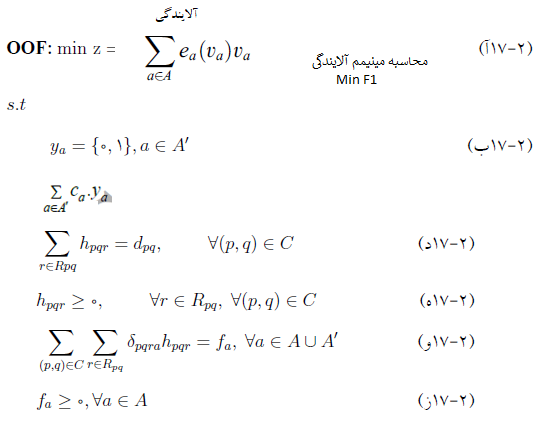

In [ ]:
#----جایگزین کردن مقادیر صفر در ماتریسها
g,h = LinkCap_Matrix.shape 
for i in range(g):
    for j in range(h):
        if LinkCap_Matrix[i][j] == 0:
            LinkCap_Matrix[i][j] = 1 
        if LinkFreeFlowTime_Matrix[i][j] == 0:
            LinkFreeFlowTime_Matrix[i][j] = 0.001 
        if LinkDistance_Matrix[i][j] == 0:
            LinkDistance_Matrix[i][j] = 0.001 
            
    

In [ ]:
model=AbstractModel()
#model=ConcreteModel()
I=AllNodesCount    #number of nodes
J=AllNodesCount    #Number of nodes
D=NodeDCount    #number of destinations
#A1=     #The set of all existing edges
#A2=    #The set of all candidate edges
#A=     #The set of all edges
A1 = AdjMatMainNet.tolist()
A2=AdjMatCandLinks.tolist()
A = AdjMatMainNetCandLinks.tolist()
cap = LinkCap_Matrix.tolist()   #Capacity
fft = LinkFreeFlowTime_Matrix.tolist() #free flow time
dst = LinkDistance_Matrix.tolist()      #distance


cst = LinkCost_Matrix.tolist()  #--Cost
d= ODDeman_Matrix    #demand between origins and destinations
e=List_D_Nodes-np.ones(24)       #destination node list
M=10**6

In [ ]:
#print(fft)
#print(cst)

In [ ]:
model.i=range(I)
model.j=range(J)
model.s=range(D)
model.x=Var(model.i,model.i,model.s,within=NonNegativeReals)
model.xx=Var(model.i,model.j,within=NonNegativeReals)
model.y=Var(model.i,model.j,within=Binary)
model.des=Var(model.s,within=NonNegativeReals)   

In [ ]:
def cns1(model,i,s):
    if i!= e[s]:
        return sum(model.x[i,j,s]*A[i][j] for j in model.j)-sum(model.x[j,i,s]*A[j][i] for j in model.j)== d[i][s]
    else:
        return sum(model.x[i,j,s]*A[i][j] for j in model.j)-sum(model.x[j,i,s]*A[j][i] for j in model.j) + model.des[s]==0
model.cns1=Constraint(model.i,model.s,rule=cns1)

In [ ]:
def cns2(model,i,j):
    return sum(model.x[i,j,s] for s in model.s) - model.xx[i,j] ==0
model.cns2=Constraint(model.i,model.j,rule=cns2)

In [ ]:
def cns3(model,i,j):
    if A2[i][j] == 1:
        return model.xx[i,j] - M*model.y[i,j] <= 0
    elif A[i][j] == 1:
        return model.xx[i,j] >=0
    else:
        return model.xx[i,j] == 0
model.cns3=Constraint(model.i,model.j,rule=cns3)

In [ ]:
def cns4(model,i,j):
    return sum(cst[i][j]*model.y[i,j] for i in model.i for j in model.j)<=Budjet
model.cns4=Constraint(model.i,model.j,rule=cns4)    

In [ ]:
# The total travel time objective function
def obj(model):
    return (0.5/2) * sum(model.xx[i,j] * (fft[i][j]*(1 + 0.15 * pow( (model.xx[i,j] / cap[i][j]),4) ) ) for i in model.i for j in model.j ) \
    + (0.5/1) * sum(fft[i][j]*(model.xx[i,j] + 0.03 * (model.xx[i,j]**5 / cap[i][j]**4)) for i in model.i for j in model.j)    
model.obj=Objective(rule=obj,sense=minimize)

In [ ]:
#Model1.xx.pprint()

In [ ]:
#opt=SolverFactory('glpk',sense=minimize)
#opt.solve(model)
Model1 = model.create_instance()

In [ ]:
import os
os.environ['NEOS_EMAIL'] = 'mehdi.zaferanieh@gmail.com' 
solver_manager = SolverManagerFactory('neos')
solver_manager.solve(Model1, solver = "knitro")   #bonmin, couenne, filmint, knitro minlp, octeract

In [ ]:
for i in model.i: 
    for j in model.j:
        if A2[i][j] == 1:
            if value(Model1.y[i,j]) == 1:
                A1[i][j]=1
                print([i+1,j+1])
A=A1

In [ ]:
for i in model.i:
    for j in model.j:
        if A2[i][j]==1:
            if value(Model1.y[i,j])>0.5:
                print([i+1,j+1])

In [ ]:
#Model1.xx.pprint()
print('Available budget:', Budjet)
for i in model.i:
    for j in model.j:
        if cst[i][j]>0:
            print([i+1,j+1], cst[i][j])

In [ ]:
model.del_component(model.obj)
model.del_component(model.cns3)
model.del_component(model.cns4)
model.del_component(model.y)
def obj(model):
    return sum(fft[i][j]*(model.xx[i,j] + 0.03 * (model.xx[i,j]**5 / cap[i][j]**4)) for i in model.i for j in model.j)
model.obj=Objective(rule=obj,sense=minimize)

In [ ]:
#print(A)
#Model1.y.pprint()
Model2 = model.create_instance()

In [ ]:
opt=SolverFactory('ipopt',sense=minimize)
opt.solve(Model2)

In [ ]:
print('Model 1 objective value:', value(Model1.obj))
print('Model 2 objective value:',value(Model2.obj))
upp_level_Model2 = sum(value(Model2.xx[i,j]) * (fft[i][j]*(1 + 0.15 * pow( (value(Model2.xx[i,j]) / cap[i][j]),4) ) ) for i in model.i for j in model.j )
upp_level_Model1 = sum(value(Model1.xx[i,j]) * (fft[i][j]*(1 + 0.15 * pow( (value(Model1.xx[i,j]) / cap[i][j]),4) ) ) for i in model.i for j in model.j )
print('Initial total travel time objective function:', upp_level_Model1)
print('final total travel time objective function:', upp_level_Model2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the matrix
matrix = [[-22056014+22092590],[-19045743+19083195],[-15671230+15699108],[-12481383+12538649],[-11477943+11537542],
         [-10305668+10377944],[-9812947+9922362],[-9126980+9202426],[-8602102+8721342]]

# Convert the matrix to a numpy array
array = np.array(matrix)

# Create x-axis values for the bar chart
x = np.arange(array.shape[0])

# Plot the bar chart
plt.bar(x, array.flatten(),width=0.4,color='blue')

# Set the x-axis tick labels
labels = ['b=5', 'b=10', 'b=15', 'b=20', 'b=25','b=30','b=35','b=40','b=45']
plt.xticks(x, labels)

# Set the x and y axis labels
plt.xlabel('Available budget')
plt.ylabel('Difference between objective values')

# Set the title of the plot
#plt.title('Bar Chart of Matrix Entries')

plt.savefig("D:/e/1234/students/basirat/code/mazandaran/result/figmedian2.png",
            dpi=200,facecolor ="w",edgecolor ='w',orientation ='landscape')

# Show the plot
plt.show()

In [ ]:
# Define the matrix
matrix = [[22092590],[19083195],[15699108],[12538649],[11537542],
         [10377944],[9922362],[9202426],[8721342]]

# Convert the matrix to a numpy array
array = np.array(matrix)

# Create x-axis values for the bar chart
x = np.arange(array.shape[0])

# Plot the bar chart
plt.bar(x, array.flatten(),width=0.4,color='red')

# Set the x-axis tick labels
labels = ['b=5', 'b=10', 'b=15', 'b=20', 'b=25','b=30','b=35','b=40','b=45']
plt.xticks(x, labels)

# Set the x and y axis labels
plt.xlabel('Available budget')
plt.ylabel('The upper level objective function value')

# Set the title of the plot
#plt.title('Bar Chart of Matrix Entries')

plt.savefig("D:/e/1234/students/basirat/code/mazandaran/result/figmedian3.png",
            dpi=200,facecolor ="w",edgecolor ='w',orientation ='landscape')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the matrix
matrix = [[-22056014+22092590],[-19045743+19083195],[-15671230+15699108],[-12481383+12538649],[-11477943+11537542],
         [-10305668+10377944],[-9812947+9922362],[-9126980+9202426],[-8602102+8721342]]

# Convert the matrix to a numpy array
array = np.array(matrix)

# Create x-axis values for the bar chart
x = np.arange(array.shape[0])

# Plot the bar chart
#colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'yellow', 'cyan', 'brown']
plt.bar(x, array.flatten(), width=0.4, color='blue')

# Set the x-axis tick labels
labels = ['b=5', 'b=10', 'b=15', 'b=20', 'b=25', 'b=30', 'b=35', 'b=40', 'b=45']
plt.xticks(x, labels)

# Set the x and y axis labels
plt.xlabel('Available budget')
plt.ylabel('Difference of initial and final solutions')

# Set the title of the plot
plt.title('Bar Chart of Matrix Entries')

# Set y-axis scale as log base 10
plt.yscale('log')
plt.savefig("D:/e/1234/students/basirat/code/mazandaran/result/figmedian2.png",
            dpi=200,facecolor ="w",edgecolor ='w',orientation ='landscape')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Define the matrix
matrix = [[-22056014+22092590],[-19045743+19083195],[-15671230+15699108],[-12481383+12538649],[-11477943+11537542],
         [-10305668+10377944],[-9812947+9922362],[-9126980+9202426],[-8602102+8721342]]

# Convert the matrix to a numpy array
array = np.array(matrix)

# Create x-axis values for the bar chart
x = np.arange(array.shape[0])

# Plot the bar chart
plt.bar(x, array.flatten(), width=0.4, color='blue')

# Set the x-axis tick labels
labels = ['b=5', 'b=10', 'b=15', 'b=20', 'b=25', 'b=30', 'b=35', 'b=40', 'b=45']
plt.xticks(x, labels)

# Set the x and y axis labels
plt.xlabel('Available budget')
plt.ylabel('Difference of initial and final solutions')

# Set the title of the plot
#plt.title('Bar Chart of Matrix Entries')

# Define the formatter function for y-axis labels
def format_y_axis(value, _):
    return f'{value / 1e4:.0f}e4'

# Apply the formatter to the y-axis labels
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis))

# Save the plot
plt.savefig("D:/e/1234/students/basirat/code/mazandaran/result/figmedian2.png",
            dpi=200, facecolor="w", edgecolor='w', orientation='landscape')

# Show the plot
plt.show()

In [ ]:
#def Teylor(model)
#    return  0.7962 * dst[i][j]/(fft[i][j]*(1 + 0.15 * pow( (model.xx[i,j] / cap[i][j]),4) )
#Total gas emission objective function
#def objEmission(model):
#    X = 0.7962 * dst[i][j]/(fft[i][j]*(1 + 0.15 * pow( (model.xx[i,j] / cap[i][j]),4) )
#    return sum(model.xx[i,j] * 0.2038 * (fft[i][j]*(1 + 0.15 * ( (model.xx[i,j] / cap[i][j])**4) * X ))  for i in model.i for j in model.j ) 
#model.obj=Objective(rule=objEmission,sense=minimize)

    
#Total gas emission objective function
#def obj(model):
    #return sum(model.xx[i,j] * 0.2038 * (fft[i][j]*(1 + 0.15 * ( (model.xx[i,j] / cap[i][j])**4) )) * exp(0.7962 * dst[i][j]/(fft[i][j]*(1 + 0.15 * pow( (model.xx[i,j] / cap[i][j]),1) ))) for i in model.i for j in model.j ) 
#    return sum((model.xx[i,j])**(-2)  for i in model.i for j in model.j)
#model.obj=Objective(rule=obj,sense=minimize)

#!pyomo help --solvers
#model.cns1.pprint()
#model.des.pprint()
#model.xx.pprint()
#model.y.pprint()
#value(model.obj)

In [ ]:
print(A1[14:15])

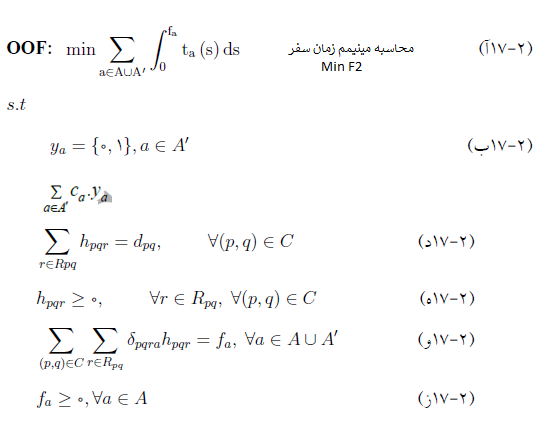

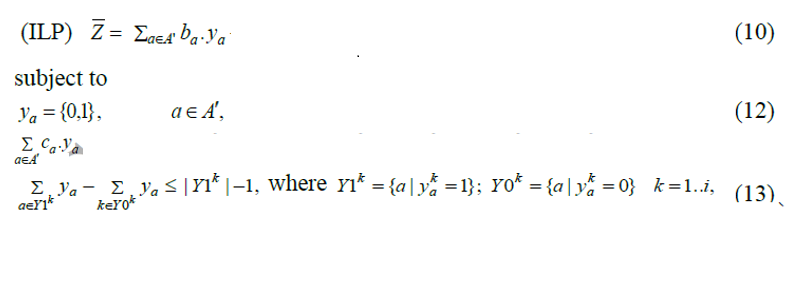